In [11]:
# Cell 1 - config & imports (edit paths)
import os, glob, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# ---------- EDIT THESE ----------
SHOT_NAME = "ChipShot"   # human name for logs
SOURCE_DIR = "data/filtered"   # folder with the per-trial preprocessed CSVs (envelope/filtered outputs)
FEATURE_DIR = "data/features" # folder where features_master.csv lives
CLUSTER_DIR = "data/clusters"
FEATURE_CSV = os.path.join(FEATURE_DIR, "features_master.csv")
GMM_LABELED = os.path.join(CLUSTER_DIR, "features_master_labeled_with_tentative.csv")
OUT_DIR = os.path.join(FEATURE_DIR, "verification_report")
os.makedirs(OUT_DIR, exist_ok=True)

print("SHOT_NAME:", SHOT_NAME)
print("SOURCE_DIR:", SOURCE_DIR)
print("FEATURE_CSV:", FEATURE_CSV)
print("GMM_LABELED:", GMM_LABELED)
print("OUT_DIR:", OUT_DIR)


SHOT_NAME: ChipShot
SOURCE_DIR: data/filtered
FEATURE_CSV: data/features\features_master.csv
GMM_LABELED: data/clusters\features_master_labeled_with_tentative.csv
OUT_DIR: data/features\verification_report


In [12]:
# Cell 2 - raw files count vs feature rows
raw_files = sorted([str(p) for p in Path(SOURCE_DIR).rglob("*.csv")])
print("Raw CSV files found:", len(raw_files))
if len(raw_files) == 0:
    raise FileNotFoundError(f"No raw CSVs found in {SOURCE_DIR}")

# load feature CSV existence
if not Path(FEATURE_CSV).exists():
    raise FileNotFoundError(f"features_master.csv not found at {FEATURE_CSV}")
feat_df = pd.read_csv(FEATURE_CSV)
print("Rows in features_master.csv:", len(feat_df))

# load labeled if exists
if Path(GMM_LABELED).exists():
    labeled_df = pd.read_csv(GMM_LABELED)
    print("Rows in labeled CSV:", len(labeled_df))
else:
    labeled_df = None
    print("Labeled CSV not present (skipping).")

# check if every raw file appears in the feature table (by 'file' column)
if 'file' in feat_df.columns:
    feat_files = set(feat_df['file'].astype(str).tolist())
    raw_set = set(raw_files)
    missing_in_feat = raw_set - feat_files
    extra_in_feat = feat_files - raw_set
    print("Raw files missing in features_master:", len(missing_in_feat))
    print("Feature rows referencing files not found in raw folder:", len(extra_in_feat))
    if len(missing_in_feat) > 0:
        print("Examples missing:", list(missing_in_feat)[:5])
    if len(extra_in_feat) > 0:
        print("Examples extra:", list(extra_in_feat)[:5])
else:
    print("'file' column not found in features_master.csv — cannot map rows to raw files.")


Raw CSV files found: 35
Rows in features_master.csv: 35
Rows in labeled CSV: 35
Raw files missing in features_master: 0
Feature rows referencing files not found in raw folder: 0


In [13]:
# Cell 3 - per-file QC from the features table
qc_list = []
for i, row in feat_df.iterrows():
    fname = row.get('file', None)
    n_samples = row.get('n_samples', np.nan)
    fs_used = row.get('fs_used', np.nan)
    # count NaNs in feature row
    nan_count = row.isna().sum()
    qc_list.append({'file': fname, 'n_samples': int(n_samples) if not np.isnan(n_samples) else None,
                    'fs_used': float(fs_used) if not np.isnan(fs_used) else None,
                    'nan_count': int(nan_count)})
qc = pd.DataFrame(qc_list)
print("Summary of n_samples in feature table:")
display(qc['n_samples'].describe())

print("\nfs_used unique values (should match sampling rate):")
print(qc['fs_used'].value_counts(dropna=False))

print("\nRows with many NaNs (top 10):")
display(qc.sort_values('nan_count', ascending=False).head(10))

# Save qc CSV
qc_path = os.path.join(OUT_DIR, "features_row_qc.csv")
qc.to_csv(qc_path, index=False)
print("Saved row QC to:", qc_path)


Summary of n_samples in feature table:


count      35.0
mean     6438.0
std         0.0
min      6438.0
25%      6438.0
50%      6438.0
75%      6438.0
max      6438.0
Name: n_samples, dtype: float64


fs_used unique values (should match sampling rate):
fs_used
2148.1481    35
Name: count, dtype: int64

Rows with many NaNs (top 10):


,file,n_samples,fs_used,nan_count
0,data\filtered\Ahesan_1.csv,6438,2148.1481,0
26,data\filtered\Soham_2.csv,6438,2148.1481,0
20,data\filtered\Nihaal_1.csv,6438,2148.1481,0
21,data\filtered\Nihaal_2.csv,6438,2148.1481,0
22,data\filtered\Nihaal_3.csv,6438,2148.1481,0
23,data\filtered\Nihaal_4.csv,6438,2148.1481,0
24,data\filtered\Nihaal_5.csv,6438,2148.1481,0
25,data\filtered\Soham_1.csv,6438,2148.1481,0
27,data\filtered\Soham_3.csv,6438,2148.1481,0
18,data\filtered\Karan_4.csv,6438,2148.1481,0


Saved row QC to: data/features\verification_report\features_row_qc.csv


In [14]:
# Cell 4 - channel name consistency (requires that features encode channel names in column names)
# Inspect columns and attempt to infer channel base names
cols = feat_df.columns.tolist()
# find unique channel prefixes by splitting on '__' (we used channel__feature naming)
chan_prefixes = set()
for c in cols:
    if '__' in c:
        chan_prefixes.add(c.split('__')[0])
chan_prefixes = sorted(list(chan_prefixes))
print("Detected channel prefixes (examples):", chan_prefixes[:20])
print("Number of detected channel prefixes:", len(chan_prefixes))

# If you expect a canonical set, validate presence
expected = ["Rectus Femoris L","Rectus Femoris R","Tibialis Anterior L","Tibialis Anterior R",
            "Gastrocnemius L","Gastrocnemius R","Hamstrings L","Hamstrings R"]
missing_expected = [e for e in expected if e not in chan_prefixes]
print("Missing expected channels (if any):", missing_expected)


Detected channel prefixes (examples): ['Gastrocnemius', 'Gastrocnemius left', 'Gastrocnemius right', 'Hamstrings', 'Hamstrings left', 'Hamstrings right', 'Rectus Femoris', 'Rectus Femoris left', 'Rectus Femoris right', 'TibilaisÂ\xa0Anterior', 'TibilaisÂ\xa0Anterior left', 'TibilaisÂ\xa0Anterior right']
Number of detected channel prefixes: 12
Missing expected channels (if any): ['Rectus Femoris L', 'Rectus Femoris R', 'Tibialis Anterior L', 'Tibialis Anterior R', 'Gastrocnemius L', 'Gastrocnemius R', 'Hamstrings L', 'Hamstrings R']


In [15]:
# Cell 5 - per-feature NaN counts and low-variance features
feat_cols = [c for c in feat_df.columns if c not in ['file','player','n_samples','fs_used','gmm_label','gmm_confidence','performance_level','performance_level_adjusted','_proxy_score']]
nan_counts = feat_df[feat_cols].isna().sum().sort_values(ascending=False)
print("Top features by NaNs (show top 20):")
display(nan_counts.head(20))

# low variance features
variances = feat_df[feat_cols].var(numeric_only=True).sort_values()
print("Lowest variance features (show bottom 20):")
display(variances.head(20))

# If many NaNs or zero-variance features appear, list them
problematic = list(nan_counts[nan_counts > (0.2 * len(feat_df))].index)  # >20% missing
print("Features with >20% missing (consider removing):", problematic)


Top features by NaNs (show top 20):


Rectus Femoris right__mean                 0
TibilaisÂ Anterior left__mrms_peak         0
TibilaisÂ Anterior left__mnf               0
TibilaisÂ Anterior left__mdf               0
TibilaisÂ Anterior left__bp_20_60          0
TibilaisÂ Anterior left__bp_60_100         0
TibilaisÂ Anterior left__bp_100_200        0
TibilaisÂ Anterior left__time_to_peak_s    0
TibilaisÂ Anterior left__dur_halfmax_s     0
TibilaisÂ Anterior left__mrms_mean         0
TibilaisÂ Anterior left__mrms_mean_rel     0
TibilaisÂ Anterior left__mrms_peak_rel     0
TibilaisÂ Anterior left__iEMG              0
Gastrocnemius right__mean                  0
Gastrocnemius right__std                   0
Gastrocnemius right__rms                   0
Gastrocnemius right__rms_rel               0
Gastrocnemius right__mav                   0
Gastrocnemius right__mav_rel               0
Gastrocnemius right__wl                    0
dtype: int64

Lowest variance features (show bottom 20):


Hamstrings right__mdf                   0.000000e+00
Rectus Femoris left__mdf                0.000000e+00
Hamstrings left__mdf                    0.000000e+00
Gastrocnemius left__mdf                 0.000000e+00
TibilaisÂ Anterior right__mdf           0.000000e+00
Rectus Femoris right__mdf               0.000000e+00
Hamstrings left__bp_100_200             3.168848e-25
Gastrocnemius right__bp_100_200         6.368173e-25
Rectus Femoris left__bp_100_200         8.860595e-25
Gastrocnemius left__bp_100_200          1.218738e-24
Rectus Femoris right__bp_100_200        2.065355e-24
Hamstrings right__bp_100_200            2.687951e-24
TibilaisÂ Anterior right__bp_100_200    2.412508e-23
Hamstrings left__bp_60_100              3.057339e-23
Gastrocnemius right__bp_60_100          6.201865e-23
Rectus Femoris left__bp_60_100          8.550062e-23
Gastrocnemius left__bp_60_100           1.174944e-22
Rectus Femoris right__bp_60_100         1.991641e-22
Hamstrings right__bp_60_100             2.6185

Features with >20% missing (consider removing): []


In [16]:
# Cell 6 - check labeled classes distribution and proxy scores (if labeled)
if labeled_df is None:
    print("No labeled file found; skip per-class checks.")
else:
    print("Performance_level_adjusted distribution:")
    print(labeled_df['performance_level_adjusted'].value_counts())

    if '_proxy_score' in labeled_df.columns:
        print("\nProxy score per level (summary):")
        display(labeled_df.groupby('performance_level_adjusted')['_proxy_score'].describe())
    # show core features progression across levels (pick a few)
    core_features = [c for c in feat_cols if '__rms' in c or '__time_to_peak' in c or 'coact' in c][:8]
    print("\nCore features sample:", core_features)
    if core_features:
        display(labeled_df.groupby('performance_level_adjusted')[core_features].mean().T)


Performance_level_adjusted distribution:
performance_level_adjusted
Excellent        10
Poor             10
Below-Average     9
Average           6
Name: count, dtype: int64

Proxy score per level (summary):


,count,mean,std,min,25%,50%,75%,max
performance_level_adjusted,,,,,,,,
Average,6.0,0.225657,1.376903,-2.385121,0.175654,0.482510,1.034206,1.482569
Below-Average,9.0,-0.146959,0.657348,-1.356976,-0.226364,-0.186421,0.182413,0.966028
Excellent,10.0,0.622611,0.952851,-0.575671,-0.150578,0.588128,1.274961,2.103000
Poor,10.0,-0.625742,0.597152,-1.410977,-1.112956,-0.502316,-0.333323,0.605080



Core features sample: ['Rectus Femoris right__rms', 'Rectus Femoris right__rms_rel', 'Rectus Femoris right__time_to_peak_s', 'Rectus Femoris left__rms', 'Rectus Femoris left__rms_rel', 'Rectus Femoris left__time_to_peak_s', 'Hamstrings right__rms', 'Hamstrings right__rms_rel']


performance_level_adjusted,Average,Below-Average,Excellent,Poor
Rectus Femoris right__rms,0.048345,0.045346,0.032596,0.017683
Rectus Femoris right__rms_rel,0.207774,0.121651,0.147480,0.069170
Rectus Femoris right__time_to_peak_s,0.888750,0.747466,0.772247,0.550567
Rectus Femoris left__rms,0.042022,0.041829,0.024953,0.013209
Rectus Femoris left__rms_rel,0.181289,0.113109,0.108807,0.058096
Rectus Femoris left__time_to_peak_s,0.886345,0.850707,0.790960,0.699021
Hamstrings right__rms,0.034749,0.036842,0.049977,0.035027
Hamstrings right__rms_rel,0.151057,0.085144,0.213259,0.152267


In [17]:
# Cell 7 - outlier detection: per-row zscore and Mahalanobis
from scipy.stats import zscore
X = feat_df[feat_cols].fillna(feat_df[feat_cols].median()).values
# per-feature zscore
z = np.abs(zscore(X, nan_policy='omit'))
row_max_z = np.nanmax(z, axis=1)
feat_df['_max_z'] = row_max_z
outliers = feat_df[feat_df['_max_z'] > 4]   # threshold
print("Outliers (max z > 4):", len(outliers))
display(outliers[['file','player','_max_z']].head(20))

# Mahalanobis distance
try:
    cov = np.cov(X, rowvar=False)
    inv_cov = np.linalg.pinv(cov)
    mean = np.nanmean(X, axis=0)
    diff = X - mean
    md = np.sqrt(np.sum(diff.dot(inv_cov) * diff, axis=1))
    feat_df['_mahalanobis'] = md
    md_outliers = feat_df[feat_df['_mahalanobis'] > np.percentile(md, 97.5)]
    print("Mahalanobis outliers (top 2.5%):", len(md_outliers))
    display(md_outliers[['file','player','_mahalanobis']].head(20))
except Exception as e:
    print("Mahalanobis failed:", e)


Outliers (max z > 4): 6


C:\Users\LaukikS\AppData\Local\Temp\ipykernel_25032\4065967536.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z = np.abs(zscore(X, nan_policy='omit'))


,file,player,_max_z
5,data\filtered\Devansh_1.csv,filtered,4.116630
10,data\filtered\Jordan_1.csv,filtered,4.943251
15,data\filtered\Karan_1.csv,filtered,5.163733
21,data\filtered\Nihaal_2.csv,filtered,4.016505
23,data\filtered\Nihaal_4.csv,filtered,5.282892
33,data\filtered\Yadnesh_4.csv,filtered,4.558751


Mahalanobis outliers (top 2.5%): 1


,file,player,_mahalanobis
27,data\filtered\Soham_3.csv,filtered,2.476547


Plotting examples: ['data\\filtered\\Devansh_1.csv', 'data\\filtered\\Jordan_1.csv', 'data\\filtered\\Ahesan_1.csv', 'data\\filtered\\Ahesan_2.csv']


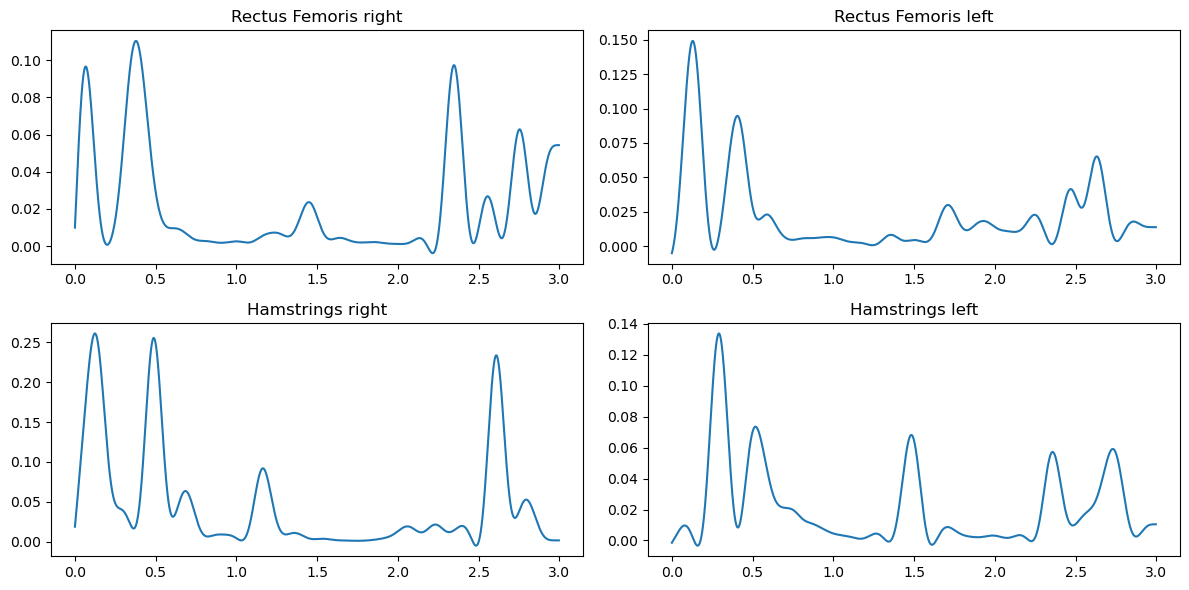

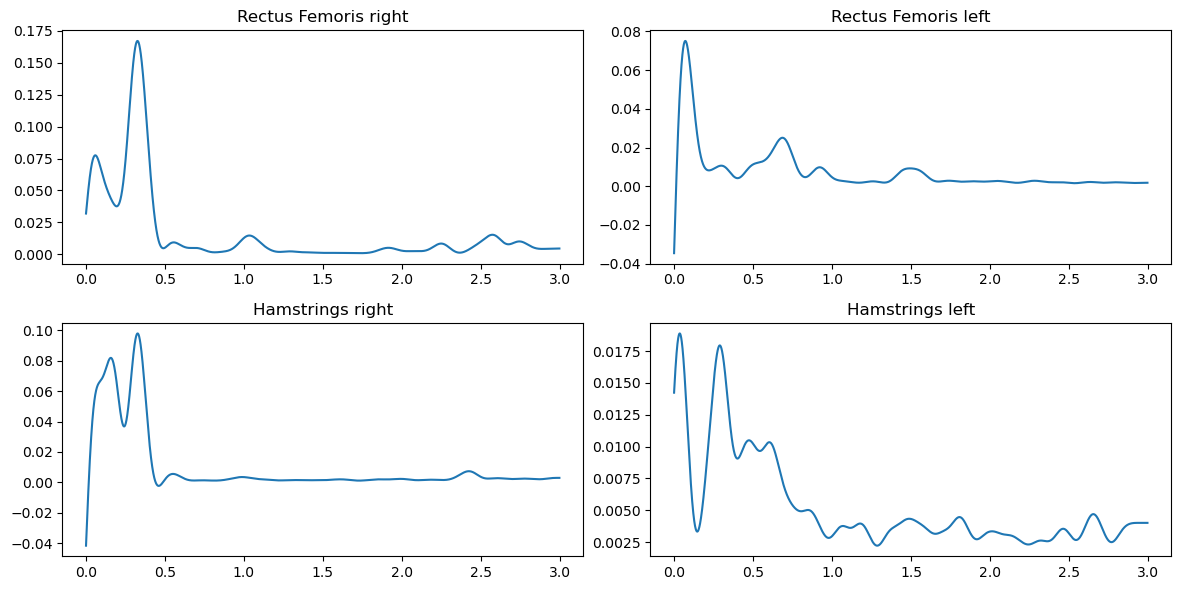

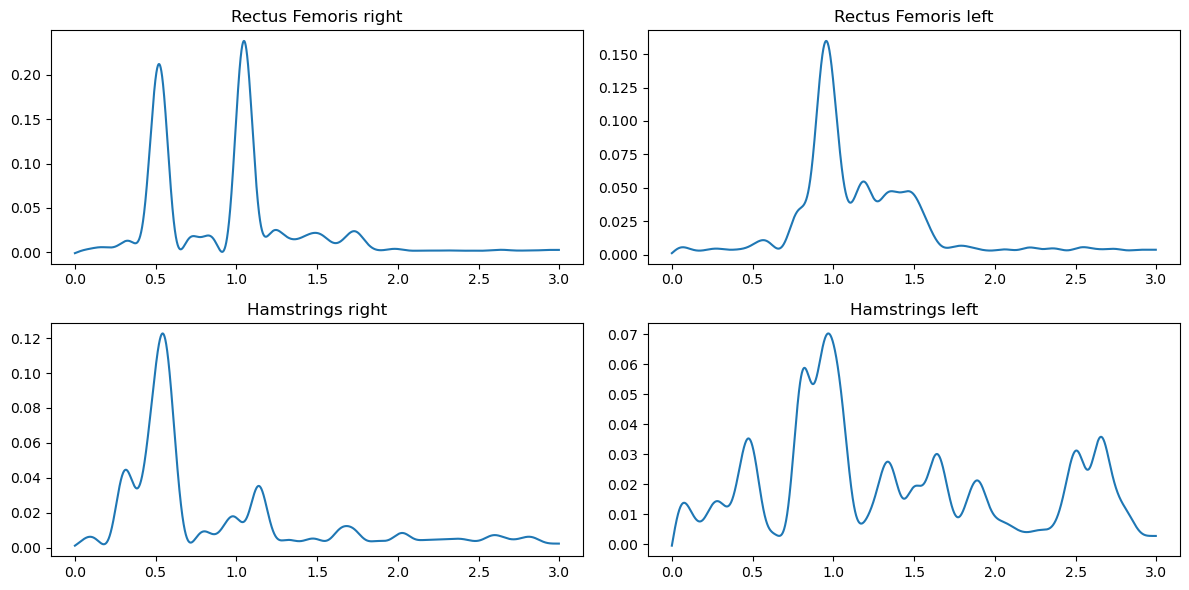

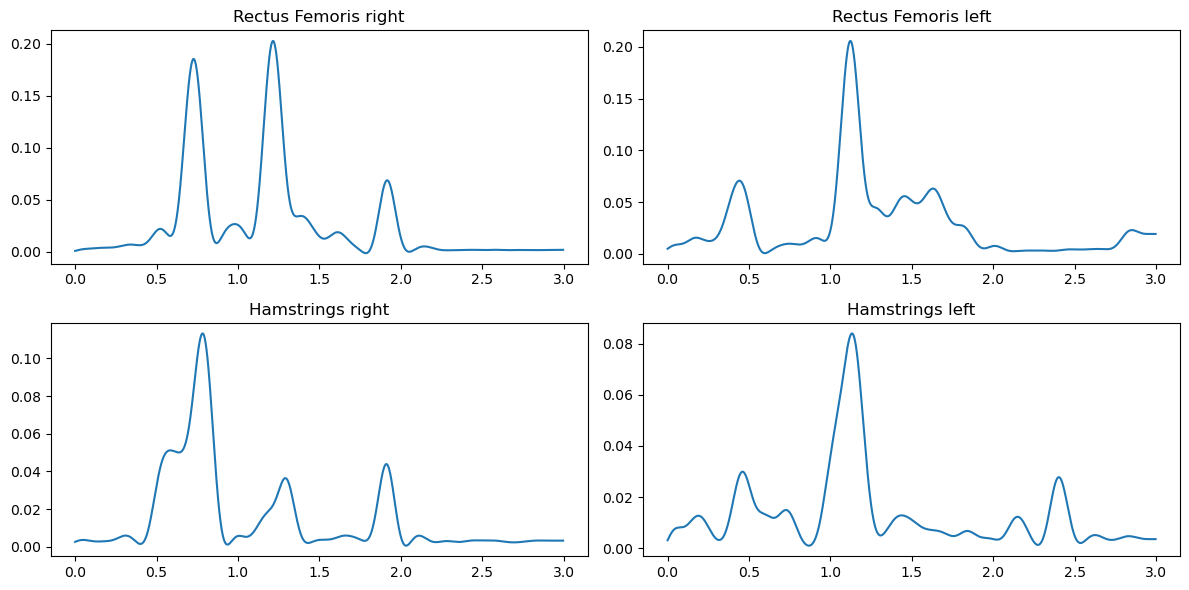

In [18]:
# Cell 8 - quick envelope plotting from a raw preprocessed CSV to visually inspect signal shape
def plot_raw_envelope(path, n_channels=4, rows=2, cols=2, start=0, stop=None):
    import pandas as pd
    df_raw = pd.read_csv(path)
    # try to find time column
    time_col = [c for c in df_raw.columns if 'time' in c.lower() or 'timestamp' in c.lower()]
    t = df_raw[time_col[0]] if len(time_col)>0 else np.arange(len(df_raw))
    emg_cols = [c for c in df_raw.columns if c not in time_col][:n_channels]
    stop = stop if stop is not None else len(df_raw)
    plt.figure(figsize=(12,6))
    for i,c in enumerate(emg_cols):
        plt.subplot(rows, cols, i+1)
        plt.plot(t[start:stop], pd.to_numeric(df_raw[c],errors='coerce').fillna(0).values[start:stop])
        plt.title(c)
    plt.tight_layout()
    plt.show()

# choose up to 4 example files: top outliers and random ones
examples = list(outliers['file'].head(2).tolist()) + raw_files[:2]
examples = [e for e in examples if e is not None][:4]
print("Plotting examples:", examples)
for p in examples:
    try:
        plot_raw_envelope(p)
    except Exception as e:
        print("Failed to plot", p, e)


In [19]:
# Cell 9 - build final X, y, players arrays used by ML and save
# Choose whether to exclude tentative samples (recommended)
exclude_tentative = True
df_for_ml = labeled_df if labeled_df is not None else feat_df.copy()
if exclude_tentative and 'performance_level_adjusted' in df_for_ml.columns:
    df_for_ml = df_for_ml[~df_for_ml['performance_level_adjusted'].astype(str).str.endswith("_TENTATIVE")].reset_index(drop=True)
    print("Excluding tentative rows. Remaining:", len(df_for_ml))

# features and meta
feature_cols_final = [c for c in df_for_ml.columns if c in feat_cols]  # intersection, preserve order
print("Final feature count:", len(feature_cols_final))
X = df_for_ml[feature_cols_final].fillna(df_for_ml[feature_cols_final].median()).values.astype(float)
y = df_for_ml['performance_level_adjusted'].astype(str).values if 'performance_level_adjusted' in df_for_ml.columns else df_for_ml['performance_level'].astype(str).values
players = df_for_ml['player'].astype(str).values

print("X shape:", X.shape, "n_classes:", len(np.unique(y)))
# basic checks
if X.shape[0] != len(df_for_ml):
    raise ValueError("Row count mismatch between X and dataframe.")
# Save numpy arrays & feature list
np.save(os.path.join(OUT_DIR, "X_verified.npy"), X)
np.save(os.path.join(OUT_DIR, "y_verified.npy"), y)
np.save(os.path.join(OUT_DIR, "players_verified.npy"), players)
pd.Series(feature_cols_final).to_csv(os.path.join(OUT_DIR, "feature_columns_verified.csv"), index=False)
print("Saved verified arrays to", OUT_DIR)


Excluding tentative rows. Remaining: 35
Final feature count: 190
X shape: (35, 190) n_classes: 4
Saved verified arrays to data/features\verification_report


In [ ]:
# Cell 10 - smoke test a simple classifier on verified data (only if class counts >=2)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

le = LabelEncoder()
y_enc = le.fit_transform(y)
class_counts = pd.Series(y).value_counts()
print("Class counts:", class_counts.to_dict())

if len(y) >= 6 and all(class_counts >= 2):
    Xtr, Xte, ytr, yte = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)
    scaler = StandardScaler().fit(Xtr)
    Xtr_s = scaler.transform(Xtr)
    Xte_s = scaler.transform(Xte)
    clf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
    clf.fit(Xtr_s, ytr)
    ypred = clf.predict(Xte_s)
    print("Smoke test classification report (holdout):")
    print(classification_report(yte, ypred, target_names=le.inverse_transform(sorted(np.unique(yte)))))
else:
    print("Not enough data for meaningful holdout smoke test. Use LOPO later with full data.")


Class counts: {'Excellent': 10, 'Poor': 10, 'Below-Average': 9, 'Average': 6}
Smoke test classification report (holdout):
               precision    recall  f1-score   support

      Average       1.00      1.00      1.00         1
Below-Average       1.00      1.00      1.00         2
    Excellent       1.00      1.00      1.00         2
         Poor       1.00      1.00      1.00         2

     accuracy                           1.00         7
    macro avg       1.00      1.00      1.00         7
 weighted avg       1.00      1.00      1.00         7

